# Convolution Neural Network

In [149]:
import torch
import numpy as np

x_shape = torch.tensor((2, 3, 4, 4))
w_shape = torch.tensor((5, 3, 4, 4))
x = torch.linspace(-0.1, 0.5, steps=torch.prod(x_shape), dtype=torch.float64, device='cpu').reshape(*x_shape)
w = torch.linspace(-0.2, 0.3, steps=torch.prod(w_shape), dtype=torch.float64, device='cpu').reshape(*w_shape)
b = torch.linspace(-0.1, 0.2, steps=5, dtype=torch.float64, device='cpu')


conv_param = {"stride": 2, "pad": 1}

# Forward & Backward Propgation

In [1]:
class Conv(object):
    def forward(x, w, b, conv_param):
        out = None
        num_train, Channel, H_x, W_x = x.shape
        num_f, Channel, H_f, W_f = w.shape
        hi = 0
        wi = 0
        stride = conv_param['stride']
        pad = conv_param['pad']

        H_out = 1 + (H_x + 2 * pad - H_f) // stride #2
        W_out = 1 + (W_x + 2 * pad - W_f) // stride
        #print(H_f)
        p2d = (pad, pad, pad, pad) # pad last dim by (pad, pad) and 2nd to last by (pad, pad)
        x_pad = torch.nn.functional.pad(x, p2d, "constant", 0)
        out = torch.zeros(num_train, num_f, H_out, W_out).to(x.dtype)
        #print(x_pad.shape)
        for k in range(num_train):
            for i in range(num_f):
                # map filter along W of image (after pad)
                #while (step_h + H_f <= H_x + 2 * pad):
                step_h = 0
                for hi in range(H_out):
                    step_w = 0
                    for wi in range(W_out):
                        #print(wi, hi)
                    #while (step_w + W_f <= W_x + 2 * pad):
                        sample = x_pad[k, :, step_h:(step_h+H_f), step_w:(step_w+W_f)]
                        #print(sample.shape, w[i,].shape, hi, wi, '\n',step_h, step_w, step_h + H_f, step_w + W_f)

                        out[k, i, hi, wi] = torch.sum(sample * w[i,]) + b[i]
                        #print(out[k,i,hi,wi], i,k,hi,wi)
                        step_w += stride
                        #wi += 1
                    step_h += stride
                    #hi += 1
                #print(out)
                #b0 = torch.sum(sample[k,] * w[i,])
        #print(out.shape)
        cache = (x, w, b, conv_param)
        return out, cache
    def backward(dout, cache):
        
        num_train, num_dout, H_dout, W_dout = dout.shape
        x, w, b, conv_param = cache
        num_train, Channel, H_x, W_x = x.shape         
        dx, dw, db = None, None, None
        dx, dw, db = torch.zeros(x.shape), torch.zeros(w.shape), torch.zeros(b.shape)
        num_f, Channel, H_f, W_f = w.shape
        pad = conv_param['pad']
        stride = conv_param['stride']

        p2d = (pad, pad, pad, pad) # pad last dim by (pad, pad) and 2nd to last by (pad, pad)
        dout_pad = torch.nn.functional.pad(dout, p2d, "constant", 0)

        x_pad = torch.nn.functional.pad(x, p2d, "constant", 0).to(x.dtype).to(x.device)
        dx_pad = torch.zeros(x_pad.shape).to(x.dtype).to(x.device)
        w_rot = w.rot90(2, [2, 3])
        _, _, H_wrot, W_wrot = w_rot.shape

        H_dw = (H_x + 2 * pad - H_dout) // stride + 1
        W_dw = (W_x + 2 * pad - W_dout) // stride + 1
        H_dx = (H_dout + 2 * pad - H_wrot) // stride + 1
        W_dx = (W_dout + 2 * pad - W_wrot) // stride + 1
            
        #print(H_dout, pad, H_wrot)        
        for k in range(num_train):
            for fi in range(num_f):
                for hi in range(H_dout):
                    step_h = hi * stride
                    for wi in range(W_dout):
                        step_w = wi * stride
                        sample = x_pad[k, :, step_h:(step_h + H_f), step_w:(step_w + W_f)]
                        dw[fi,] += sample * dout[k, fi, hi, wi]
                        dx_pad[k, :, step_h:(step_h+H_f), step_w:(step_w+W_f)] += w[fi,] * dout[k, fi, hi, wi]

        dx = dx_pad[:, :, pad:(pad+H_x), pad:(pad+W_x)]
                        
#         for k in range(num_train):
#             for i in range(num_f):
#                 step_h_dw, step_h_dx = 0, 0
#                 for hi_dw in range(H_dw):
#                     step_w_dw = 0
#                     for wi_dw in range(W_dw):
#                         for c in range(Channel):
#                             sample_x = x_pad[k, c, step_h_dw:(step_h_dw + H_dout),step_w_dw:(step_w_dw + W_dout)]
#                             # dW = X conv. dout
#                             dw[i, c, hi_dw, wi_dw] += torch.sum(sample_x * dout[k, i,])
#                         step_w_dw += stride
#                     step_h_dw += stride
#                 #print(H_dx)
#                 for hi_dx in range(H_dx):
#                     #print(hi_dx)
#                     step_w_dx = 0
#                     for wi_dx in range(W_dx):
#                         for c in range(Channel):            
#                             sample_dout = dout_pad[k,i,step_h_dx:(step_h_dx+H_wrot),step_w_dx:(step_w_dx+W_wrot)]

#                             # dX = dout_pad conv. W_rot
#                             dx[k, c, hi_dx, wi_dx] += torch.sum(sample_dout * w_rot[i, c,])
#                         step_w_dx += stride
#                     step_h_dx += stride
        db = dout.sum(dim=3).sum(dim=2).sum(dim=0)

        
        
        
        
        return dx, dw, db

In [151]:
conv_param = {"stride": 2, "pad": 1}
out, cache = Conv.forward(x, w, b, conv_param)
dout = torch.randn(2, 5, 2, 2, dtype=torch.float64, device='cpu')
#out, cache = Conv.forward(x, w, b, conv_param)
dx, dw, db = Conv.backward(dout, cache)
print(dx)

tensor([[[[ 0.1070,  0.3512,  0.3540,  0.2535],
          [ 0.3160,  0.7542,  0.7459,  0.4306],
          [ 0.3039,  0.7208,  0.7125,  0.4092],
          [ 0.1997,  0.3031,  0.2920,  0.0865]],

         [[ 0.0872,  0.3953,  0.3981,  0.3173],
          [ 0.2678,  0.6207,  0.6123,  0.3452],
          [ 0.2558,  0.5873,  0.5789,  0.3239],
          [ 0.1713,  0.1255,  0.1144, -0.0627]],

         [[ 0.0675,  0.4394,  0.4421,  0.3811],
          [ 0.2196,  0.4871,  0.4787,  0.2598],
          [ 0.2076,  0.4537,  0.4454,  0.2385],
          [ 0.1429, -0.0521, -0.0632, -0.2119]]],


        [[[ 0.5363,  1.0828,  1.0789,  0.5449],
          [ 0.8612,  0.8683,  0.8563, -0.0027],
          [ 0.8422,  0.8201,  0.8080, -0.0320],
          [ 0.3120, -0.2634, -0.2715, -0.5836]],

         [[ 0.5027,  1.0193,  1.0154,  0.5150],
          [ 0.7851,  0.6754,  0.6633, -0.1196],
          [ 0.7661,  0.6271,  0.6151, -0.1489],
          [ 0.2695, -0.3928, -0.4009, -0.6706]],

         [[ 0.4692,  0.9559,

## other result CN

In [255]:
Back Propagation

def conv_forward(x, w, b, conv_param):
  """
  A naive implementation of the forward pass for a convolutional layer.
  The input consists of N data points, each with C channels, height H and
  width W. We convolve each input with F different filters, where each filter
  spans all C channels and has height HH and width WW.

  Input:
  - x: Input data of shape (N, C, H, W)
  - w: Filter weights of shape (F, C, HH, WW)
  - b: Biases, of shape (F,)
  - conv_param: A dictionary with the following keys:
    - 'stride': The number of pixels between adjacent receptive fields in the
    horizontal and vertical directions.
    - 'pad': The number of pixels that will be used to zero-pad the input. 
    
  During padding, 'pad' zeros should be placed symmetrically (i.e equally on both sides)
  along the height and width axes of the input. Be careful not to modfiy the original
  input x directly.

  Returns a tuple of:
  - out: Output data, of shape (N, F, H', W') where H' and W' are given by
    H' = 1 + (H + 2 * pad - HH) / stride
    W' = 1 + (W + 2 * pad - WW) / stride
  - cache: (x, w, b, conv_param)
  """
  out = None
  ##############################################################################
  # TODO: Implement the convolutional forward pass.                            #
  # Hint: you can use the function torch.nn.functional.pad for padding.        #
  # Note that you are NOT allowed to use anything in torch.nn in other places. #
  ##############################################################################
  # Replace "pass" statement with your code
  N, C, H, W = x.shape
  F, _, HH, WW = w.shape
  stride = conv_param.get('stride', 1)
  pad = conv_param.get('pad', 0)
  # Check for parameter sanity
  assert (H + 2 * pad - HH) % stride == 0, 'Sanity Check Status: Conv Layer Failed in Height'
  assert (W + 2 * pad - WW) % stride == 0, 'Sanity Check Status: Conv Layer Failed in Width'
  H_prime = 1 + (H + 2 * pad - HH) // stride
  W_prime = 1 + (W + 2 * pad - WW) // stride
  # Padding
#   x_pad = np.pad(x, ((0, 0), (0, 0), (pad, pad), (pad, pad)), 'constant', constant_values=0)
  x_pad = torch.nn.functional.pad(x, (pad,pad,pad,pad)).to(x.dtype).to(x.device)
  # Construct output
  out = torch.zeros((N, F, H_prime, W_prime)).to(x.dtype).to(x.device)
  # Naive Loops
  for n in range(N):
      for f in range(F):
          for j in range(0, H_prime):
              for i in range(0, W_prime):
                  out[n, f, j, i] = (x_pad[n, :, j*stride:j*stride+HH, i*stride:i*stride+WW] * w[f, :, :, :]).sum() + b[f]
  #############################################################################
  #                              END OF YOUR CODE                             #
  #############################################################################
  cache = (x, w, b, conv_param)
  return out, cache










def conv_backward(dout, cache):
  """
  A naive implementation of the backward pass for a convolutional layer.

  Inputs:
  - dout: Upstream derivatives.
  - cache: A tuple of (x, w, b, conv_param) as in conv_forward_naive

  Returns a tuple of:
  - dx: Gradient with respect to x
  - dw: Gradient with respect to w
  - db: Gradient with respect to b
  """
  dx, dw, db = None, None, None
  #############################################################################
  # TODO: Implement the convolutional backward pass.                          #
  #############################################################################
  # Replace "pass" statement with your code
#   db=torch.sum(dout,[0,1,3])# Extract shapes and constants
  x, w, b, conv_param = cache
  N, C, H, W = x.shape
  F, _, HH, WW = w.shape
  stride = conv_param.get('stride', 1)
  pad = conv_param.get('pad', 0)
  # Padding
  x_pad = torch.nn.functional.pad(x, (pad,pad,pad,pad)).to(x.dtype).to(x.device)
  H_prime = 1 + (H + 2 * pad - HH) // stride
  W_prime = 1 + (W + 2 * pad - WW) // stride
  # Construct output
  dx_pad = torch.zeros_like(x_pad).to(x.dtype).to(x.device)
  dx = torch.zeros_like(x).to(x.dtype).to(x.device)
  dw = torch.zeros_like(w).to(x.dtype).to(x.device)
  db = torch.zeros_like(b).to(x.dtype).to(x.device)
  # Naive Loops
  for n in range(N):
      for f in range(F):
          db[f] += torch.sum(dout[n, f])
          for j in range(0, H_prime):
              for i in range(0, W_prime):
                  dw[f] += x_pad[n, :, j * stride:j * stride + HH, i * stride:i * stride + WW] * dout[n, f, j, i]
                  dx_pad[n, :, j * stride:j * stride + HH, i * stride:i * stride + WW] += w[f] * dout[n, f, j, i]
    # Extract dx from dx_pad
  dx = dx_pad[:, :, pad:pad+H, pad:pad+W]
  #############################################################################
  #                              END OF YOUR CODE                             #
  #############################################################################
  return dx, dw, db


# CN Backward check 1

In [135]:


x = torch.randn(4, 3, 5, 5, dtype=torch.float64, device='cpu')
w = torch.randn(2, 3, 3, 3, dtype=torch.float64, device='cpu')
b = torch.randn(2, dtype=torch.float64, device='cpu')
dout = torch.randn(4, 2, 5, 5, dtype=torch.float64, device='cpu')
conv_param = {'stride': 1, 'pad': 1}
dout = torch.randn(4, 2, 5, 5, dtype=torch.float64, device='cpu')
# dout = torch.randn(2, 5, 2, 2, dtype=torch.float64, device='cpu')
num_train, num_dout, H_dout, W_dout = dout.shape

num_train, Channel, H_x, W_x = x.shape        
# x, w, b, conv_param = cache
dx, dw, db = None, None, None
dx, dw, db = torch.zeros(x.shape), torch.zeros(w.shape), torch.zeros(b.shape)
#print(dx.type(), dw.type(), db.type())
num_f, Channel, H_f, W_f = w.shape
pad = conv_param['pad']
stride = conv_param['stride']
# pad_back = (1, 1, 1, 1)
p2d = (pad, pad, pad, pad) # pad last dim by (pad, pad) and 2nd to last by (pad, pad)
dout_pad = torch.nn.functional.pad(dout, p2d, "constant", 0)
#print(dout_pad.shape)
x_pad = torch.nn.functional.pad(x, p2d, "constant", 0)
dx_pad = torch.zeros(x_pad.shape).to(x.dtype).to(x.device)
w_rot = w.rot90(2, [2, 3])
_, _, H_wrot, W_wrot = w_rot.shape
#print(w.shape, w_rot.shape)
# step_h = 0
# step_w = 0
# hi = 0
# wi = 0
H_dw = (H_x + 2 * pad - H_dout) // stride + 1
W_dw = (W_x + 2 * pad - W_dout) // stride + 1
H_dx = (H_dout + 2 * pad - H_wrot) // stride + 1
W_dx = (W_dout + 2 * pad - W_wrot) // stride + 1
#print(H_dout, pad, H_wrot)
for k in range(num_train):
    for i in range(num_f):
        step_h_dw, step_h_dx = 0, 0
        for hi_dw in range(H_f):
            step_w_dw = 0
        #while(step_h <= H_x + 2 * pad - H_dout):
            for wi_dw in range(W_f):
            #while(step_w <= W_x + 2 * pad -W_dout):
                for c in range(Channel):
                    sample_x = x_pad[k, c, step_h_dw:(step_h_dw + H_dout), step_w_dw:(step_w_dw + W_dout)]
                    print('dw', sample_x.shape, dout.shape)
                    # dW = X conv. dout
                    dw[i, c, hi_dw, wi_dw] += torch.sum(sample_x * dout[k, i,])
                step_w_dw += pad
            step_h_dw += pad
        #print(H_dx)
        for hi_dx in range(H_x):
            #print(hi_dx)
            step_w_dx = 0
            for wi_dx in range(W_x):
                for c in range(Channel):            
                    sample_dout = dout_pad[k, i, step_h_dx:(step_h_dx + H_wrot), step_w_dx:(step_w_dx + W_wrot)]
                    print('dx', sample_dout.shape, w_rot.shape, step_w_dx,(step_w_dx + W_wrot))
                    # dX = dout_pad conv. W_rot
                    dx[k, c, hi_dx, wi_dx] += torch.sum(sample_dout * w_rot[i, c,])
                    #print(sample_dout*w_rot[i, c,], hi_dx, wi_dx)
                    #print(hi_dx, wi_dx, i, k, c)
                step_w_dx += pad
            step_h_dx += pad
db = dout.sum(dim=3).sum(dim=2).sum(dim=0).float()
# dx=dx.double()
#print(db)
#print(dw.shape)
#print(dx.type(), dw.type(), db.type())


dw torch.Size([5, 5]) torch.Size([4, 2, 5, 5])
dw torch.Size([5, 5]) torch.Size([4, 2, 5, 5])
dw torch.Size([5, 5]) torch.Size([4, 2, 5, 5])
dw torch.Size([5, 5]) torch.Size([4, 2, 5, 5])
dw torch.Size([5, 5]) torch.Size([4, 2, 5, 5])
dw torch.Size([5, 5]) torch.Size([4, 2, 5, 5])
dw torch.Size([5, 5]) torch.Size([4, 2, 5, 5])
dw torch.Size([5, 5]) torch.Size([4, 2, 5, 5])
dw torch.Size([5, 5]) torch.Size([4, 2, 5, 5])
dw torch.Size([5, 5]) torch.Size([4, 2, 5, 5])
dw torch.Size([5, 5]) torch.Size([4, 2, 5, 5])
dw torch.Size([5, 5]) torch.Size([4, 2, 5, 5])
dw torch.Size([5, 5]) torch.Size([4, 2, 5, 5])
dw torch.Size([5, 5]) torch.Size([4, 2, 5, 5])
dw torch.Size([5, 5]) torch.Size([4, 2, 5, 5])
dw torch.Size([5, 5]) torch.Size([4, 2, 5, 5])
dw torch.Size([5, 5]) torch.Size([4, 2, 5, 5])
dw torch.Size([5, 5]) torch.Size([4, 2, 5, 5])
dw torch.Size([5, 5]) torch.Size([4, 2, 5, 5])
dw torch.Size([5, 5]) torch.Size([4, 2, 5, 5])
dw torch.Size([5, 5]) torch.Size([4, 2, 5, 5])
dw torch.Size

dx torch.Size([3, 3]) torch.Size([2, 3, 3, 3]) 4 7
dx torch.Size([3, 3]) torch.Size([2, 3, 3, 3]) 4 7
dx torch.Size([3, 3]) torch.Size([2, 3, 3, 3]) 0 3
dx torch.Size([3, 3]) torch.Size([2, 3, 3, 3]) 0 3
dx torch.Size([3, 3]) torch.Size([2, 3, 3, 3]) 0 3
dx torch.Size([3, 3]) torch.Size([2, 3, 3, 3]) 1 4
dx torch.Size([3, 3]) torch.Size([2, 3, 3, 3]) 1 4
dx torch.Size([3, 3]) torch.Size([2, 3, 3, 3]) 1 4
dx torch.Size([3, 3]) torch.Size([2, 3, 3, 3]) 2 5
dx torch.Size([3, 3]) torch.Size([2, 3, 3, 3]) 2 5
dx torch.Size([3, 3]) torch.Size([2, 3, 3, 3]) 2 5
dx torch.Size([3, 3]) torch.Size([2, 3, 3, 3]) 3 6
dx torch.Size([3, 3]) torch.Size([2, 3, 3, 3]) 3 6
dx torch.Size([3, 3]) torch.Size([2, 3, 3, 3]) 3 6
dx torch.Size([3, 3]) torch.Size([2, 3, 3, 3]) 4 7
dx torch.Size([3, 3]) torch.Size([2, 3, 3, 3]) 4 7
dx torch.Size([3, 3]) torch.Size([2, 3, 3, 3]) 4 7
dw torch.Size([5, 5]) torch.Size([4, 2, 5, 5])
dw torch.Size([5, 5]) torch.Size([4, 2, 5, 5])
dw torch.Size([5, 5]) torch.Size([4, 2,

## CN Backprop check 2

In [148]:
x = torch.randn(10, 3, 31, 31, dtype=torch.float64, device='cpu')
w = torch.randn(25, 3, 3, 3, dtype=torch.float64, device='cpu')
b = torch.randn(25, dtype=torch.float64, device='cpu')
dout = torch.randn(10, 25, 16, 16, dtype=torch.float64, device='cpu')
#x_cuda, w_cuda, b_cuda, dout_cuda = x.to('cuda'), w.to('cuda'), b.to('cuda'), dout.to('cuda')
conv_param = {'stride': 2, 'pad': 1}

dx, dw, db = None, None, None
num_train, num_dout, H_dout, W_dout = dout.shape
#x, w, b, conv_param = cache
num_train, Channel, H_x, W_x = x.shape         

dx = torch.zeros(x.shape).to(x.dtype).to(x.device)
dw, db = torch.zeros(w.shape).to(w.dtype).to(w.device), torch.zeros(b.shape).to(b.dtype).to(b.device)
num_f, Channel, H_f, W_f = w.shape
pad = conv_param['pad']
stride = conv_param['stride']

p2d = (pad, pad, pad, pad) # pad last dim by (pad, pad) and 2nd to last by (pad, pad)
dout_pad = torch.nn.functional.pad(dout, p2d, "constant", 0).to(x.dtype).to(x.device)

x_pad = torch.nn.functional.pad(x, p2d, "constant", 0).to(x.dtype).to(x.device)
dx_pad = torch.zeros(x_pad.shape).to(x.dtype).to(x.device)
w_rot = w.rot90(2, [2, 3])
_, _, H_wrot, W_wrot = w_rot.shape

H_dw = 1 + ((H_x + 2 * pad - H_dout) // stride)
W_dw = (W_x + 2 * pad - W_dout) // stride + 1
H_dx = (H_dout + 2 * pad - H_wrot) // stride + 1
W_dx = (W_dout + 2 * pad - W_wrot) // stride + 1
print(H_dout, 'x', H_x, 'dx',H_dx, 'w',H_wrot,'dw', H_dw)

# for k in range(num_train):
#     for i in range(num_f):
#         step_h_dw, step_h_dx = 0, 0
#         for hi_dw in range(H_f):
#             step_w_dw = 0
#         #while(step_h <= H_x + 2 * pad - H_dout):
#             for wi_dw in range(W_f):
#             #while(step_w <= W_x + 2 * pad -W_dout):
#                 for c in range(Channel):
#                     sample_x = x_pad[k, c, step_h_dw:(step_h_dw + H_dout), step_w_dw:(step_w_dw + W_dout)]
#                     #print('dw', sample_x.shape, dout.shape)
#                     # dW = X conv. dout
#                     dw[i, c, hi_dw, wi_dw] += torch.sum(sample_x * dout[k, i,])
#                 step_w_dw += pad
#             step_h_dw += pad
#         #print(H_dx)
#         for hi_dx in range(H_dx):
#             #print(hi_dx)
#             step_w_dx = 0
#             for wi_dx in range(W_x):
#                 for c in range(Channel):            
#                     sample_dout = dout_pad[k, i, step_h_dx:(step_h_dx + H_wrot), step_w_dx:(step_w_dx + W_wrot)]
#                     #print('dx', sample_dout.shape, w_rot.shape, step_w_dx,(step_w_dx + W_wrot))
#                     # dX = dout_pad conv. W_rot
#                     dx[k, c, hi_dx, wi_dx] += torch.sum(sample_dout * w_rot[i, c,])
#                     #print(sample_dout*w_rot[i, c,], hi_dx, wi_dx)
#                     #print(hi_dx, wi_dx, i, k, c)
#                 step_w_dx += pad
#             step_h_dx += pad

for k in range(num_train):
    for fi in range(num_f):
        for hi in range(H_out):
            step_h = hi * stride
            for wi in range(W_out):
                step_w = wi * stride
                sample = x_pad[k, :, step_h:(step_h + H_f), step_w:(step_w + W_f)]
                dw[fi,] += sample * dout[k, fi, hi, wi]
                dx_pad[k, :, step_h:(step_h+H_f), step_w:(step_w+W_f)] += w[fi,] * dout[k, fi, hi, wi]

dx = dx_pad[:, :, pad:(pad+H_f), pad:(pad+W_f)]

db = dout.sum(dim=3).sum(dim=2).sum(dim=0).float()
print('dx',dx.shape,'x', x.shape, '\n','w', w.shape,'dw', dw.shape)
#print(dx)

16 x 31 dx 8 w 3 dw 9
dx torch.Size([10, 3, 3, 3]) x torch.Size([10, 3, 31, 31]) 
 w torch.Size([25, 3, 3, 3]) dw torch.Size([25, 3, 3, 3])


In [103]:
x = torch.randn(10, 3, 31, 31, dtype=torch.float64, device='cpu')
w = torch.randn(25, 3, 3, 3, dtype=torch.float64, device='cpu')
b = torch.randn(25, dtype=torch.float64, device='cpu')
dout = torch.randn(10, 25, 16, 16, dtype=torch.float64, device='cpu')
#x_cuda, w_cuda, b_cuda, dout_cuda = x.to('cuda'), w.to('cuda'), b.to('cuda'), dout.to('cuda')
conv_param = {'stride': 2, 'pad': 1}

dx, dw, db = None, None, None
num_train, num_dout, H_dout, W_dout = dout.shape
#x, w, b, conv_param = cache
num_train, Channel, H_x, W_x = x.shape         

dx = torch.zeros(x.shape).to(x.dtype).to(x.device)
dw, db = torch.zeros(w.shape).to(w.dtype).to(w.device), torch.zeros(b.shape).to(b.dtype).to(b.device)
num_f, Channel, H_f, W_f = w.shape
pad = conv_param['pad']
stride = conv_param['stride']

p2d = (pad, pad, pad, pad) # pad last dim by (pad, pad) and 2nd to last by (pad, pad)
dout_pad = torch.nn.functional.pad(dout, p2d, "constant", 0).to(x.dtype).to(x.device)

x_pad = torch.nn.functional.pad(x, p2d, "constant", 0).to(x.dtype).to(x.device)
w_rot = w.rot90(2, [2, 3])
_, _, H_wrot, W_wrot = w_rot.shape

H_dw = 1 + ((H_x + 2 * pad - H_dout) // stride)
W_dw = (W_x + 2 * pad - W_dout) // stride + 1
H_dx = (H_dout + 2 * pad - H_wrot) // stride + 1
W_dx = (W_dout + 2 * pad - W_wrot) // stride + 1


b0 = torch.zeros(b.shape).to(b.dtype).to(b.device)
dw, _ = Conv.forward(x_pad, dout, b0, conv_param)

RuntimeError: The size of tensor a (3) must match the size of tensor b (25) at non-singleton dimension 0

# Maxpool

In [67]:
class MaxPool(object):
    @staticmethod
    def forward(x, pool_param):

        out = None
        #hi, wi = 0, 0
        H_pool, W_pool, stride = pool_param['pool_height'], pool_param['pool_width'], pool_param['stride']
        num_train, Channel, H_x, W_x = x.shape
        H_out = 1 + (H_x - H_pool) // stride #2
        W_out = 1 + (W_x - W_pool) // stride
        out = torch.zeros(num_train, Channel, H_out, W_out).to(x.dtype)
        for k in range(num_train):
            for c in range(Channel):
                for hi in range(H_out):
                    step_h = stride * hi
                    for wi in range(W_out):
                        step_w = stride * wi

                        sample = x[k, c, step_h:(step_h+H_pool), step_w:(step_w+W_pool)]


                        out[k, c, hi, wi] = torch.max(sample)

                     
                       
        cache = (x, pool_param)
        return out, cache

    @staticmethod
    def backward(dout, cache):

        dx = None
        x, pool_param = cache
        num_train, Channel, H_x, W_x = x.shape
        num_train_dout, Channel_dout, H_dout, W_dout = dout.shape
        H_pool, W_pool, stride = pool_param['pool_height'], pool_param['pool_width'], pool_param['stride']
        H_out = 1 + (H_x - H_pool) // stride
        W_out = 1 + (W_x - W_pool) // stride
        assert H_out == H_dout
        assert W_out == W_dout
        dx = torch.zeros(num_train, Channel, H_x, W_x).to(x.dtype)
        # maxpooling derivation samilar to ReLU, max element of matrix is 1, others are 0
        for k in range(num_train):
            for c in range(Channel):
                for hi in range(H_out):
                    step_hi = hi * stride
                    for wi in range(W_out):
                        step_wi = wi * stride
                        sample = x[k, c, step_hi:(step_hi + H_pool), step_wi:(step_wi + W_pool)]
                        mask = (sample == torch.max(sample))
                        #print(step_wi,(step_wi+W_pool))
                        dx[k, c, step_hi:(step_hi+H_pool), step_wi:(step_wi+W_pool)] += mask * dout[k, c, hi, wi]
                        
        return dx

## Maxpool check forward

In [66]:
x_shape = torch.tensor((2, 3, 4, 4))
x = torch.linspace(-0.3, 0.4, steps=torch.prod(x_shape), dtype=torch.float64, device='cpu').reshape(*x_shape)
pool_param = {'pool_width': 2, 'pool_height': 2, 'stride': 2}

# out, _ = MaxPool.forward(x, pool_param)


out = None
hi, wi = 0, 0
H_pool, W_pool, stride = pool_param['pool_height'], pool_param['pool_width'], pool_param['stride']
num_train, Channel, H_x, W_x = x.shape
H_out = 1 + (H_x - H_pool) // stride #2
W_out = 1 + (W_x - W_pool) // stride
out = torch.zeros(num_train, Channel, H_out, W_out).to(x.dtype)
# for k in range(num_train):
#     for c in range(Channel):
#         #step_h = 0
#         for hi in range(H_out):
#             step_h = stride * hi
#             #step_w = 0
#             for wi in range(W_out):
#                 step_w = stride * wi

#                 sample = x[k, c, step_h:(step_h+H_pool), step_w:(step_w+W_pool)]
#                 out[k, c, hi, wi] = torch.max(sample)
                
                #step_w += stride
            #step_h += stride
            
for j in range(H_out):
    for i in range(W_out):
        # torch.max(max, max_indices)
        out[:,:,j,i]=\
        torch.max(torch.max(x[:,:,j*stride:j*stride+H_pool,i*stride:i*stride+W_pool],-1)[0],-1)[0]

print(torch.max(x[:,:,j*stride:j*stride+H_pool,i*stride:i*stride+W_pool],-1)[0].shape)
print(torch.max(torch.max(x[:,:,j*stride:j*stride+H_pool,i*stride:i*stride+W_pool],-1)[0],-1)[0].shape)           
            
            
print(out.shape)

torch.Size([2, 3, 2])
torch.Size([2, 3])
torch.Size([2, 3, 2, 2])


## Maxpool check backward

In [35]:
dx = None
x = torch.randn(3, 2, 8, 8, dtype=torch.float64, device='cpu')
dout = torch.randn(3, 2, 4, 4, dtype=torch.float64, device='cpu')
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}
#x, pool_param = cache
#N, C, num_H, num_W = x.shape
num_train, Channel, H_x, W_x = x.shape
num_train_dout, Channel_dout, H_dout, W_dout = dout.shape
H_pool, W_pool, stride = pool_param['pool_height'], pool_param['pool_width'], pool_param['stride']
H_out = 1 + (H_x - H_pool) // stride
W_out = 1 + (W_x - W_pool) // stride
assert H_out == H_dout
assert W_out == W_dout
dx = torch.zeros(num_train, Channel, H_x, W_x).to(x.dtype)
# maxpooling derivation samilar to ReLU, max element of matrix is 1, others are 0
for k in range(num_train):
    for c in range(Channel):
        for hi in range(H_out):
            step_hi = hi * stride
            for wi in range(W_out):
                step_wi = wi * stride
                sample = x[k, c, step_hi:(step_hi + H_pool), step_wi:(step_wi + W_pool)]
                mask = (sample == torch.max(sample))
                #print(dout[k,c,hi,wi])
                dx[k, c, step_hi:(step_hi+H_pool), step_wi:(step_wi+W_pool)] += mask * dout[k, c, hi, wi]

print(dx.shape)

tensor(0.4193, dtype=torch.float64)
tensor(-0.3992, dtype=torch.float64)
tensor(-0.3965, dtype=torch.float64)
tensor(-0.9121, dtype=torch.float64)
tensor(-0.9329, dtype=torch.float64)
tensor(-0.0462, dtype=torch.float64)
tensor(-2.5075, dtype=torch.float64)
tensor(1.0759, dtype=torch.float64)
tensor(-1.4200, dtype=torch.float64)
tensor(-1.0733, dtype=torch.float64)
tensor(-1.3824, dtype=torch.float64)
tensor(-1.0670, dtype=torch.float64)
tensor(-0.1734, dtype=torch.float64)
tensor(0.8926, dtype=torch.float64)
tensor(1.1544, dtype=torch.float64)
tensor(-1.6205, dtype=torch.float64)
tensor(1.0106, dtype=torch.float64)
tensor(-0.3823, dtype=torch.float64)
tensor(0.8630, dtype=torch.float64)
tensor(-1.4630, dtype=torch.float64)
tensor(-0.2756, dtype=torch.float64)
tensor(-0.0920, dtype=torch.float64)
tensor(-0.6111, dtype=torch.float64)
tensor(0.1542, dtype=torch.float64)
tensor(0.4628, dtype=torch.float64)
tensor(1.2150, dtype=torch.float64)
tensor(0.0716, dtype=torch.float64)
tensor(-1.0

## check Maxpool class

In [68]:
x = torch.randn(3, 2, 8, 8, dtype=torch.float64, device='cpu')
dout = torch.randn(3, 2, 4, 4, dtype=torch.float64, device='cpu')
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

dx_num = compute_numeric_gradient(lambda x: MaxPool.forward(x, pool_param)[0], x, dout)

out, cache = MaxPool.forward(x, pool_param)
dx = MaxPool.backward(dout, cache)

print('Testing MaxPool.backward function:')
print('dx error: ', rel_error(dx, dx_num))

Testing MaxPool.backward function:
dx error:  6.962721153203535e-10


In [173]:
a = torch.rand(3).to(dtype=torch.double)
b = torch.rand(3).to(dtype=torch.float64)
print(a, b, b.dot(a))

tensor([0.2193, 0.3153, 0.6177], dtype=torch.float64) tensor([0.1178, 0.0942, 0.8627], dtype=torch.float64) tensor(0.5884, dtype=torch.float64)


## CN test forward of image

torch.Size([2, 2, 100, 100])


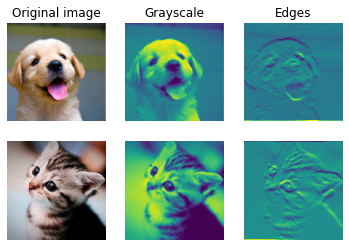

In [284]:
from imageio import imread
from PIL import Image
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

kitten_url = 'https://web.eecs.umich.edu/~justincj/teaching/eecs498/assets/a3/kitten.jpg'
puppy_url = 'https://web.eecs.umich.edu/~justincj/teaching/eecs498/assets/a3/puppy.jpg'

kitten = imread(kitten_url)
puppy = imread(puppy_url)
# kitten is wide, and puppy is already square
d = kitten.shape[1] - kitten.shape[0]
kitten_cropped = kitten[:, d//2:-d//2, :]

img_size = 100   # Make this smaller if it runs too slow
resized_puppy = ToTensor()(Image.fromarray(puppy).resize((img_size, img_size)))
resized_kitten = ToTensor()(Image.fromarray(kitten_cropped).resize((img_size, img_size)))
x = torch.stack([resized_puppy, resized_kitten])

# Set up a convolutional weights holding 2 filters, each 3x3
w = torch.zeros(2, 3, 3, 3, dtype=x.dtype)

# The first filter converts the image to grayscale.
# Set up the red, green, and blue channels of the filter.
w[0, 0, :, :] = torch.tensor([[0, 0, 0], [0, 0.3, 0], [0, 0, 0]])
w[0, 1, :, :] = torch.tensor([[0, 0, 0], [0, 0.6, 0], [0, 0, 0]])
w[0, 2, :, :] = torch.tensor([[0, 0, 0], [0, 0.1, 0], [0, 0, 0]])

# Second filter detects horizontal edges in the blue channel.
w[1, 2, :, :] = torch.tensor([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

# Vector of biases. We don't need any bias for the grayscale
# filter, but for the edge detection filter we want to add 128
# to each output so that nothing is negative.
b = torch.tensor([0, 128], dtype=x.dtype)

# Compute the result of convolving each input in x with each filter in w,
# offsetting by b, and storing the results in out.
out, _ = Conv.forward(x, w, b, {'stride': 1, 'pad': 1})
#out, _ = conv_forward(x, w, b, {'stride': 1, 'pad': 1})
print(out.shape)

def imshow_no_ax(img, normalize=True):
  """ Tiny helper to show images as uint8 and remove axis labels """
  if normalize:
    img_max, img_min = img.max(), img.min()
    img = 255.0 * (img - img_min) / (img_max - img_min)
  plt.imshow(img)
  plt.gca().axis('off')

# Show the original images and the results of the conv operation
plt.subplot(2, 3, 1)
imshow_no_ax(puppy, normalize=False)
plt.title('Original image')
plt.subplot(2, 3, 2)
imshow_no_ax(out[0, 0])
plt.title('Grayscale')
plt.subplot(2, 3, 3)
imshow_no_ax(out[0, 1])
plt.title('Edges')
plt.subplot(2, 3, 4)
imshow_no_ax(kitten_cropped, normalize=False)
plt.subplot(2, 3, 5)
imshow_no_ax(out[1, 0])
plt.subplot(2, 3, 6)
imshow_no_ax(out[1, 1])
plt.show()

## Numerical gradient

In [4]:
def compute_numeric_gradient(f, x, dLdf=None, h=1e-7):
    """
    Compute the numeric gradient of f at x using a finite differences
    approximation. We use the centered difference:

    df    f(x + h) - f(x - h)
    -- ~= -------------------
    dx           2 * h

    Function can also expand this easily to intermediate layers using the
    chain rule:

    dL   df   dL
    -- = -- * --
    dx   dx   df

    Inputs:
    - f: A function that inputs a torch tensor and returns a torch scalar
    - x: A torch tensor giving the point at which to compute the gradient
    - dLdf: optional upstream gradient for intermediate layers
    - h: epsilon used in the finite difference calculation
    Returns:
    - grad: A tensor of the same shape as x giving the gradient of f at x
    """
    flat_x = x.contiguous().flatten()
    grad = torch.zeros_like(x)
    flat_grad = grad.flatten()

    # Initialize upstream gradient to be ones if not provide
    if dLdf is None:
        y = f(x)
        dLdf = torch.ones_like(y)
    dLdf = dLdf.flatten()

    # iterate over all indexes in x
    for i in range(flat_x.shape[0]):
        oldval = flat_x[i].item()  # Store the original value
        flat_x[i] = oldval + h  # Increment by h
        fxph = f(x).flatten()  # Evaluate f(x + h)
        flat_x[i] = oldval - h  # Decrement by h
        fxmh = f(x).flatten()  # Evaluate f(x - h)
        flat_x[i] = oldval  # Restore original value

        # compute the partial derivative with centered formula
        dfdxi = (fxph - fxmh) / (2 * h)

        # use chain rule to compute dLdx
        flat_grad[i] = dLdf.dot(dfdxi).item()
        #flat_grad[i] = dLdf.float().dot(dfdxi).item()

    # Note that since flat_grad was only a reference to grad,
    # we can just return the object in the shape of x by returning grad
    return grad


def rel_error(x, y, eps=1e-10):
    """
    Compute the relative error between a pair of tensors x and y,
    which is defined as:

                            max_i |x_i - y_i]|
    rel_error(x, y) = -------------------------------
                      max_i |x_i| + max_i |y_i| + eps

    Inputs:
    - x, y: Tensors of the same shape
    - eps: Small positive constant for numeric stability

    Returns:
    - rel_error: Scalar giving the relative error between x and y
    """
    """ returns relative error between x and y """
    top = (x - y).abs().max().item()
    bot = (x.abs() + y.abs()).clamp(min=eps).max().item()
    return top / bot


## check CN

In [154]:
x = torch.randn(4, 3, 5, 5, dtype=torch.float64, device='cpu')
w = torch.randn(2, 3, 3, 3, dtype=torch.float64, device='cpu')
b = torch.randn(2, dtype=torch.float64, device='cpu')
dout = torch.randn(4, 2, 5, 5, dtype=torch.float64, device='cpu')
conv_param = {'stride': 1, 'pad': 1}

dx_num = compute_numeric_gradient(lambda x: Conv.forward(x, w, b, conv_param)[0], x, dout)
dw_num = compute_numeric_gradient(lambda w: Conv.forward(x, w, b, conv_param)[0], w, dout)
db_num = compute_numeric_gradient(lambda b: Conv.forward(x, w, b, conv_param)[0], b, dout)

# dx_num = compute_numeric_gradient(lambda x: conv_forward(x, w, b, conv_param)[0], x, dout)
# dw_num = compute_numeric_gradient(lambda w: conv_forward(x, w, b, conv_param)[0], w, dout)
# db_num = compute_numeric_gradient(lambda b: conv_forward(x, w, b, conv_param)[0], b, dout)


out, cache = Conv.forward(x, w, b, conv_param)
dx, dw, db = Conv.backward(dout, cache)

print('Testing Conv.backward function')
print('dx error: ', rel_error(dx, dx_num))
print('dw error: ', rel_error(dw, dw_num))
print('db error: ', rel_error(db, db_num))

Testing Conv.backward function
dx error:  0.9543557584755171
dw error:  0.9045464002227771
db error:  1.0663381379043285e-09
